<a href="https://colab.research.google.com/github/yusras99/Anime_recommender/blob/main/CSC461_project_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Loading in Datasets / Features**

## **Data Description**

Our Data has two files - *anime.csv* and *rating.csv*
The features in Anime.csv include the following:
>1.   **anime_id** - myanimelist.net's unique id identifying an anime.
2.   **name**- full name of anime.
3. **genre** - comma separated list of genres for this anime.
4. **type** - movie, TV, OVA, etc.
5. **episodes**- how many episodes in this show. (1 if movie).
6. **rating** - average rating out of 10 for this anime.
7. **members** - number of community members that are in this anime's "group".

While the features in ratings.csv include the following:

>1. **user_id** - non identifiable randomly generated user id.
2. **anime_id** - the anime that this user has rated.
3. **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).





Important Decisions we took before solving collaborative filtering

>1. How should we handle -1 ratings, as it means the user has not rated yet?

We mean centered our data, by assigning mean for any rating that was -1 for our user. This approach would help us in solving cosine similarity for our model.

>2. Do we throw out missing data?

Since our data was very sparse, as every user wouldn't have rated each anime, so there were nans for the missing ratings for the animes. Hence, we used those animes to predict ratings for the user.
>3. What features do we need for user based?

We used all three features for prediction as we need to know which user gave ranking to which anime. A user-anime interaction matrix was formed that was used for our cosine similarity, where columns were anime_id and rows were user_ids while the values in the matrix were ratings.

>4. What features do we need for item based?
>5. How do we define centered cosine similarity for our purpose?

Cosine similarity is used to get a score of similarity between users so that the users with high similarity can be used for prediction of another user's rating. We mean centered our data, and for any nans we imputed 0 in it so cosine similarity can work.

>6.(Once done) how can we refine our collab filtering with these additional features like members?

## **1. Access Data**

In [ ]:
#Mount google drive and load in full datasets

#Our notes:
#For user based, it seems that ratings.csv would be sufficient. Will try this first


import pandas as pd
from google.colab import drive


drive.mount('/content/drive')
%cd '/content/drive/My Drive'


anime = pd.read_csv('/content/drive/MyDrive/CSC461_FinalProject/anime.csv')
ratings = pd.read_csv('/content/drive/MyDrive/CSC461_FinalProject/rating.csv')

# The file that will have all the recommended movies for the user, along with its rmse error.
out_file_path = '/content/drive/MyDrive/CSC461_FinalProject/out-file.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


# **2. Preprocessing/EDA**

In [ ]:
#Preprocessing/ Exploratory Data Analysis //MAYBE TAKE OUT THIS SECTION


#Shapes of ratings
print("Ratings shape: ",ratings.shape)
#Shapes of anime

print("Anime shape: ",anime.shape)

import numpy as np

rating_data_arr = np.array(ratings)
user_id = np.array(ratings.user_id)
user_rating = np.array(ratings.rating)
anime_id = np.array(ratings.anime_id)
print(rating_data_arr.shape)
print("Amount of -1's: ",np.count_nonzero(rating_data_arr == -1))
print("Amount of ratings: ",len(rating_data_arr)- np.count_nonzero(rating_data_arr == -1))
print("Percent of non-ratings: ", 100 *( 1-(len(rating_data_arr)-np.count_nonzero(rating_data_arr==-1))/len(rating_data_arr)))

Ratings shape:  (7813737, 3)
Anime shape:  (12294, 7)
(7813737, 3)
Amount of -1's:  1476496
Amount of ratings:  6337241
Percent of non-ratings:  18.896156858107716


#**3. Data Visualization**

Text(0.5, 1.0, 'Rating of animes based on user')

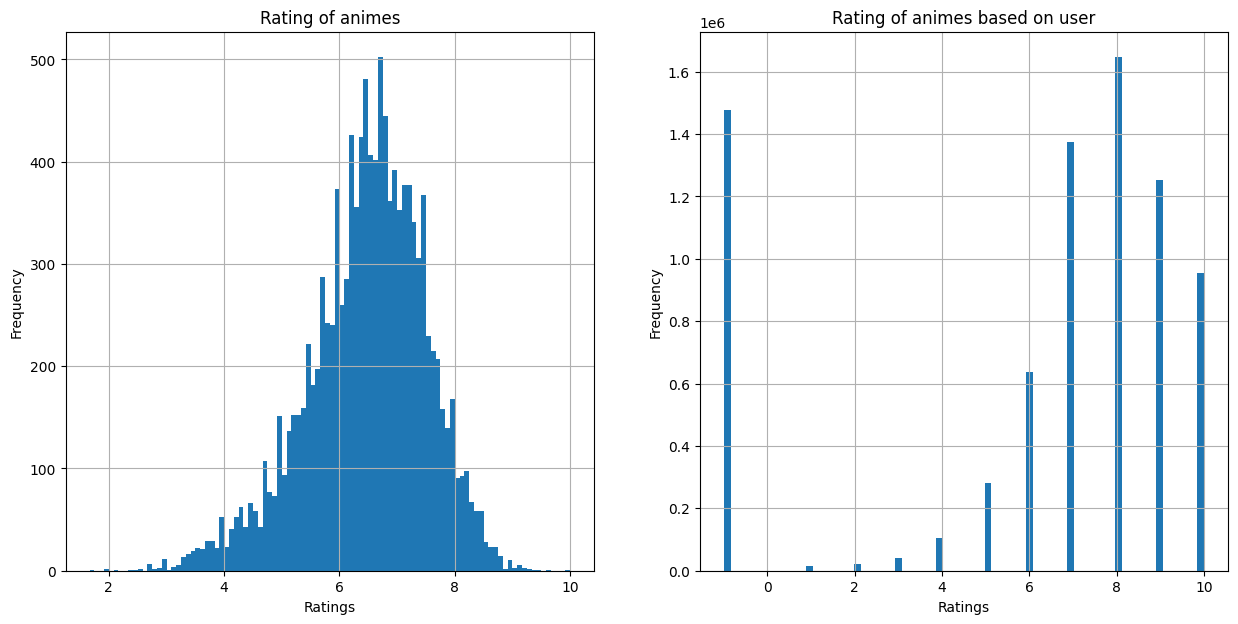

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
#Distribution of ratings
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
anime['rating'].hist(bins=100)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
# Display the frequency of ratings given to animes by all users
plt.title("Rating of animes")

plt.subplot(1,2,2)
ratings['rating'].hist(bins=70)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
# Display the frequency of ratings given by animes to all users
plt.title("Rating of animes based on user")

# **4.Mean-center Data**






In [ ]:
# We are going to mean center our data .For each user, subtract the mean from each one of their ratings as to remove the bias of a "tough grader" or an "easy grader".
# We also calculated stats on how many nAn ratings there are, and how many actual ratings there are.
# NB:

unique_users = np.unique(user_id)

def get_rating_counts():
    max_user_id = max(unique_users)
    # Array of total non-ratings of each user
    user_total_non_ratings = np.zeros(max_user_id + 1)  # Adjust size based on the maximum user ID
    start_index = 0
    #This keeps track of how many ratings each user has given. To access user 5's rating, you would call user_ratings_count[5-1].
    user_ratings_count = np.zeros(max_user_id+1)
    #Iterate through unique users, to calculate their mean
    for user in unique_users:
      count = 0
      non_ratings = 0
      # go over the rating_data_arr and if the current rating
      for i in range(start_index, len(rating_data_arr)):
        iter = rating_data_arr[i]
        if iter[0] == user:
          #If non_ratings, then add them to populate the non_rating array
          if iter[2] == -1:
            non_ratings += 1
            rating_data_arr[iter][2] = 0
          else:
            count+=1 #count total number of ratings for the user
        else:
          start_index = i
          break
      user_total_non_ratings[user] = non_ratings
      user_ratings_count[user] = count
    start_index = 0;
    for user in unique_users:
      for i in range(start_index, len(rating_data_arr)):
        iter = rating_data_arr[i]
        if iter[0] != user:
          start_index = i
          break
    return  user_ratings_count

#Get user ratings count : the actual number of ratings each user has given
user_ratings_count = get_rating_counts()



# **Thresholding/Cosine Similarity Matrix**

In [ ]:
#Here, we are thresholding our users, by allowing only users who have rated a certain amount of anime or higher. This serves a twofold purpose: it increases the quality
#of our users(less erratic / noisy data) and decreases the computational cost. Here, we also impute the NAN ratings (where the user has seen the show and not watched it) with
#the mean (0). Then, we can calculate the cosine similarity for the next steps(the similarity calculations between users).

from sklearn.metrics.pairwise import cosine_similarity

# Threshold is the number of animes a user has rated for it to be considered in cosine similarity
threshold = 1000
indices_above_thresh = np.where(user_ratings_count > threshold)[0]

print("The total number of users that rated above ",threshold, "animes are: ",len(indices_above_thresh))
mask = np.isin(rating_data_arr[:, 0], indices_above_thresh)

# Use the mask to select the rows that has the users that we selected
rows_above_thresh = rating_data_arr[mask]

#Create pivot table, which relates each user to every anime,

ratings = pd.DataFrame(rows_above_thresh)

anime_df = pd.DataFrame(anime)

ratings.rename(columns = {'0':'user_id','1':'anime_id','2':'rating'}, inplace = True)

ratings.head(5)

cols = ['user_id','anime_id','rating']
ratings.columns = cols

#Here we are building our pivot table . Mean center after this !

user_ratings_matrix_nans_present = pd.pivot_table(ratings,values='rating', index='user_id', columns='anime_id')

#Centering function . Takes row and subtracts it by mean of whole row (each row is a user's ratings )
mean_center = lambda x: x-np.mean(x)

user_ratings_matrix_nans_present = user_ratings_matrix_nans_present.apply(mean_center,axis = 1)


#Impute the NAN values with the mean this makes cosine similarity possible
user_ratings_matrix_normalized = user_ratings_matrix_nans_present.fillna(0)

user_similarities = cosine_similarity(user_ratings_matrix_normalized)

#Making it readable! This way we know which two users we are comparing
user_similarities_df = pd.DataFrame(user_similarities, index = user_ratings_matrix_normalized.index, columns = user_ratings_matrix_normalized.index)



user_ratings_matrix_normalized

The total number of users that rated above  1000 animes are:  165


anime_id,1,5,6,7,8,15,16,17,18,19,...,34107,34119,34238,34240,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
1497,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.085577,0.000000,...,0.0,0.0,0.000000,1.085577,0.0,0.000000,0.000000,0.0,0.0,0.0
1530,-4.788510,-3.788510,0.211490,0.211490,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2951,-0.898822,-0.898822,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.101178,...,0.0,0.0,0.000000,0.000000,0.0,-8.898822,0.000000,0.0,0.0,0.0
3569,4.096078,3.096078,1.096078,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5310,0.000000,0.000000,0.000000,0.000000,0.0,1.397747,0.000000,0.397747,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67348,0.594028,0.594028,0.594028,-0.405972,0.0,0.000000,-0.405972,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.594028,0.0,0.000000,0.000000,0.0,0.0,0.0
67666,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.669819,0.000000,0.000000,0.330181,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
68084,0.000000,0.000000,0.880556,0.000000,0.0,0.880556,-0.119444,0.000000,0.000000,0.880556,...,0.0,0.0,0.000000,0.880556,0.0,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# This function finds unwatched and watched anime for the user. This allows for us to recommend an anime which the user hasn't seen, and test other functions

import math
def find_unwatched_watched_anime(user):
  watched_list = []
  unwatched_list = []
  for index in user_ratings_matrix_nans_present.loc[user].index:
   if not math.isnan(user_ratings_matrix_nans_present.loc[user][index]):
    watched_list.append(index)
   elif math.isnan(user_ratings_matrix_nans_present.loc[user][index]):
    unwatched_list.append(index)
   else:
    raise Exception("Something went wrong with type checking")

  return (unwatched_list,watched_list)

unwatched_list , watched_list = find_unwatched_watched_anime(7345)




In [ ]:
#Item based : Get name of item, create releates items to other items
item_cosine_similarity = cosine_similarity(user_ratings_matrix_normalized.T)
item_similarities_df = pd.DataFrame(item_cosine_similarity, index = user_ratings_matrix_normalized.columns, columns = user_ratings_matrix_normalized.columns)


In [ ]:
#Given an a user and a number of recommendations to give ( by default 5, as user based is giving that many as well,
#Return a list of 5 anime that are similar to the user's highest rated anime. Go into watched list, get highest rated anime theyve seen, go into unwatched list, find 5 most
#similar items.


def similar_anime(user,unwatched,watched, num_anime_recs = 5):
  user_watched_list = pd.DataFrame(user_ratings_matrix_normalized,columns = watched).loc[user]
  max_score_anime_id = user_watched_list.idxmax()
  top_similar_anime = item_similarities_df.loc[max_score_anime_id].sort_values(ascending= False)
  #Get indexes of most similar anime (by default 5). Only look at shows that are unwatched by the user , as we dont want to recommend stuff they've seen.
  top_similar_anime = top_similar_anime.reindex(unwatched)
  top_similar_anime = top_similar_anime[1:num_anime_recs+1].index
  # print("Here are your recomendations! : ")
  # for anime in top_similar_anime:
  # print(get_anime_name(anime))

  return top_similar_anime



In [ ]:
def item_based(user):
  unwatched,watched = find_unwatched_watched_anime(user)

  return similar_anime(user,unwatched,watched)

In [ ]:
#Prediction + Finding similar users
from IPython.display import display

# This function will return (by default) the top 10 users with the highest similarity value , but
def top_sim_users(user,num_neighbors = 15):

    # check if the current user is in the data fram or not.
    if user not in user_ratings_matrix_normalized.index:
        print("No data available on user {} because it didn't rate enough movies".format(user))
        return None

    elif num_neighbors > len(indices_above_thresh):
      print('Number of neighbors is more than total amount of users who rated animes above threshold i.e {} users'.format(len(indices_above_thresh)))
      return None

    #If none of the neighbros are close enough in similarity to our user, call item
    else:
      pass

    # Sort the similarities of this user in descending order based on their score and grab the 10 highest scores
    top_similar_scores = user_similarities_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:num_neighbors+1]
    # Now grab the users whose top 10 scores were grabbed in previous step. Also always grab from index 1 onwards, because index zero is itself.
    top_similar_users = user_similarities_df.sort_values(by=user, ascending=False).index[1:num_neighbors+1]
    top_sim_user_sim_scores_zipped = zip(top_similar_users, top_similar_scores,)
    # return top_user_scores_zipped in list form
    return list(top_sim_user_sim_scores_zipped)

In [ ]:
def predict_rating(anime_id,user, top_sim_user_sim_scores ):
  rating_list = np.array([])
  weight_list = np.array([])
  top_users = np.array([])
  # if and only if the current user had top users then continue else switch to item_based.
  if  top_sim_user_sim_scores != None:
    for i, (sim_user, similarity_score) in enumerate(top_sim_user_sim_scores):
        # for each top_user who has rated the particular anime, get their ratings, and only use it for prediction if rating is not nan
        rating_for_anime = user_ratings_matrix_nans_present.loc[sim_user, anime_id]
        #this decreases the available neighbors by a lot . This is a known problem of sparse datasets in recommendation problems.
        #Continue to next user  if this user does not have a rating for this anime ,its of no use to us
        if np.isnan(rating_for_anime):
             continue
        elif not np.isnan(rating_for_anime):
            # Populate rating list, top_user list and weight list where similarity score is the weight that will be added to the ratings
            top_users = np.append(top_users, sim_user)
            rating_list = np.append(rating_list, rating_for_anime)
            weight_list = np.append(weight_list, similarity_score)
    # calculate avg of weight so that the total sum of all weights is 1, and we can see the total contribution of each user in the ratings.
    weight_list = weight_list / weight_list.sum()
    # multiply ratings with new weights, to get weighted average of each of the ratings
    weighted_avg_rating = rating_list * weight_list
    weighted_avg_rating_df =  pd.DataFrame({"User": top_users, "rating list": rating_list})
    return weighted_avg_rating.sum()
  else:
    return item_based(user)

In [ ]:
#Get anime name given the ID( give this while recommending)
def get_anime_name(anime_num):
  for i in anime_df.loc[(anime_df['anime_id'] == anime_num)]['name']:
    return i

#Vice versa of above. Gets the id number given the anime name
def get_anime_id(anime_name):
  for i in anime_df.loc[(anime_df['name'] == anime_name)]['anime_id']:
    return i


In [ ]:
#TODO: Ideally, this anime would not be randomly selected and would be selected based on popularity ,
# so that users are recommended popular items that are more likely to be highly rated by many users

def give_recommendations(user,num_neighbors=15):
  if user in indices_above_thresh: #if the current user has rated animes above thresh
    # Get the top users for the current user based on cosine similarity
    top_user_and_scores = top_sim_users(user, num_neighbors)

    best_ratings = []
    most_common_animes = {}
    for sim_user, sim_score in top_user_and_scores:
      #get the max ratings of each user
      max_score = user_ratings_matrix_normalized.loc[sim_user].max()
      # max_score = user_ratings_matrix_normalized.loc[user_ratings_matrix_normalized[sim_user] not in watched].max()
      #get the anime which had the best rating
      max_ratings_anime_ids = user_ratings_matrix_normalized.loc[sim_user][user_ratings_matrix_normalized.loc[sim_user] == max_score].index.tolist()
      best_ratings.append(max_ratings_anime_ids)
    #go through all the best ratings list
    for i in range(len(best_ratings)):
      # for each anime of each user's best list, see if it was common in other similar users.
      for j in best_ratings[i]:
        if j in most_common_animes:
          most_common_animes[j] += 1
        else:
          most_common_animes[j] = 1
     #sort the list of movies based on the number of occurences of each movie
    sorted_list = sorted(most_common_animes.items(), key=operator.itemgetter(1), reverse=True)
    #return top five movies
    return sorted_list[:5]
  else:
    print("The user {} has rated shows below the threshold so we can't find similar users for it. We will use item-based approach for this.".format(user))
    unwatched,watched = find_unwatched_watched_anime(user)
    return similar_anime(user,unwatched,watched)



In [ ]:
import operator
from sklearn.metrics import mean_squared_error

total_error = []
all_users_anime_lists = []
for user in indices_above_thresh:
  unwatched,watched = find_unwatched_watched_anime(user)
  # get the similar users of the current user
  sim_users = top_sim_users(user)

  #Go to item based if no similar users i.e. similarity score is below 0.2
  #Cant calculate error for item based , because we are only recommending movies that are watched.
  if(sim_users[0][1] < 0.2):
    top_5_anime_id_list_item_based = item_based(user)
    top_5_anime_item_based=[]
    # convert anime_ids to their respective anime_names
    for anime_id in top_5_anime_id_list_item_based:
      top_5_anime_item_based.append(get_anime_name(anime_id))
    # store the data in the respective columns
    user_data = {'User': user, 'Anime List': top_5_anime_item_based,'ApproachType': "item-based", 'RMSE Error':"N/A for item-based"}
    # Append the data to the master list which will be appended to the dataframe
    all_users_anime_lists.append(user_data)
  else:
    # compute user based otherwise
    actual_ratings = []
    predicted_ratings = []
    user_error = []
    # to calculate error, predict ratings using our model and get the actual rating to get the score
    for i in watched:
      actual = user_ratings_matrix_normalized.loc[user,i]
      pred = predict_rating(i,user,sim_users)
      actual_ratings.append(actual)
      predicted_ratings.append(pred)
      user_error.append(mean_squared_error(predicted_ratings,actual_ratings,squared = False))
    # The average error for all the movies predicted for this user
    mean_user_error = np.mean(user_error)
    total_error.append(mean_user_error)
    # This list contains top 5 animes, and its frequency of this movie watched among its similar users
    top_5_anime_freq_list = give_recommendations(user)
    top_5_anime_id_list_user_based = [t[0] for t in top_5_anime_freq_list]
    top_5_anime_user_based=[]
    # make a list of top 5 anime names
    for anime_id in top_5_anime_id_list_user_based:
      top_5_anime_user_based.append(get_anime_name(anime_id))
    user_data = {'User': user, 'Anime List': top_5_anime_user_based,'ApproachType': "user-based", 'RMSE Error':mean_user_error}
    all_users_anime_lists.append(user_data)
user_recommendation_df = pd.DataFrame(all_users_anime_lists)
display(user_recommendation_df)
# Get the average error among all users to test our model accuracy
print("Average error across users: ", np.mean(total_error))

# Save the DataFrame to the CSV file
user_recommendation_df.to_csv(out_file_path, index=True)

,User,Anime List,ApproachType,RMSE Error
0,1497,"[Clannad: After Story, Steins;Gate, Fate/Zero ...",user-based,1.524706
1,1530,"[Eyeshield 21, Hachimitsu to Clover, Hungry He...",item-based,N/A for item-based
2,2951,"[Witch Hunter Robin, Beet the Vandel Buster, E...",item-based,N/A for item-based
3,3569,"[Fullmetal Alchemist: Brotherhood, Death Note,...",user-based,1.150183
4,5310,"[Code Geass: Hangyaku no Lelouch R2, Fullmetal...",user-based,1.381504
...,...,...,...,...
160,67348,"[Eyeshield 21, Hungry Heart: Wild Striker, Ini...",item-based,N/A for item-based
161,67666,"[Code Geass: Hangyaku no Lelouch R2, Fullmetal...",user-based,1.071777
162,68084,"[Clannad: After Story, Fullmetal Alchemist: Br...",user-based,1.099759
163,68797,"[Clannad: After Story, Steins;Gate, Fullmetal ...",user-based,0.947169


Average error across users:  1.3795227911854246
